This notebook aims to test our framework it the purely gaussian case.

## Validate the gaussian prior

In [1]:
# Script for training a denoiser
import os

os.environ['XLA_FLAGS']='--xla_gpu_cuda_data_dir=/gpfslocalsys/cuda/10.1.2'

In [2]:
%load_ext autoreload
%autoreload 2 
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
from absl import app
from absl import flags
import haiku as hk
import jax
#import optax
from jax.experimental import optix
import jax.numpy as jnp
import numpy as onp
import pickle
from functools import partial

from flax.metrics import tensorboard

# Import tensorflow for dataset creation and manipulation
import tensorflow.compat.v2 as tf
tf.enable_v2_behavior()
import tensorflow_datasets as tfds

#from jax_lensing.models.convdae import UResNet, SmallUResNet
from jax_lensing.inversion import ks93inv, ks93
from jax_lensing.models.convdae2 import MediumUResNet
from jax_lensing.models.normalization import SNParamsTree as CustomSNParamsTree
from jax_lensing.spectral import measure_power_spectrum, make_power_map
from jax_lensing.utils import load_dataset
from tqdm.notebook import tqdm

from astropy.io import fits

import types
from typing import Mapping, Optional, Sequence, Union

In [4]:
dataset = "kappatng"
#weight_dir = "../weights/gp-sn1v2"
batch_size = 32
gaussian_prior = True
gaussian_path = "../data/ktng/ktng_PS_theory.npy"
map_size = 360
resolution = 0.29
train_split = "90%"
noise_dist_std = 0.2
sigma_gamma = 0.148

In [5]:
def log_gaussian_prior(map_data, sigma, ps_map):
    data_ft = jnp.fft.fft2(map_data) / float(map_size)
    return -0.5*jnp.sum(jnp.real(data_ft*jnp.conj(data_ft)) / (ps_map+sigma[0]**2))

gaussian_prior_score = jax.vmap(jax.grad(log_gaussian_prior), in_axes=[0,0, None])

In [6]:
# load convergence maps
train_set = load_dataset(dataset,
                         batch_size,
                         map_size,
                         noise_dist_std,
                         train_split)

dict_keys(['x', 'y', 'u', 's'])


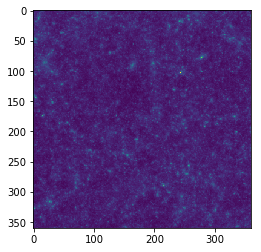

In [7]:
batch = next(train_set)
print(batch.keys())
imshow(batch['x'][0,...,0])

Compute PS from a map

In [8]:
pixel_size = jnp.pi * resolution / 180. / 60. #rad/pixel
ell, power_spectrum_1d = measure_power_spectrum(batch['x'][0,...,0], pixel_size)
ps_data_map = jnp.stack([ell, power_spectrum_1d], axis=0)

Import theoretical PS

In [9]:
ps_data_th = onp.load(gaussian_path).astype('float32')

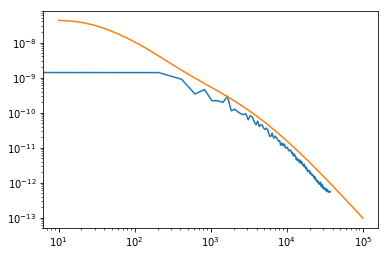

In [10]:
loglog(ps_data_map[0,:], ps_data_map[1,:])
loglog(ps_data_th[0,:], ps_data_th[1,:])

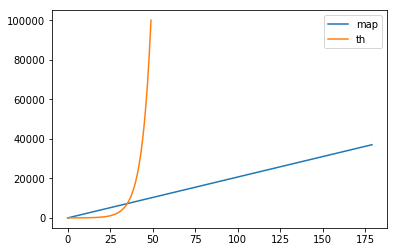

In [11]:
plot(ps_data_map[0,:], label='map')
plot(ps_data_th[0,:], label='th')
legend()

In [12]:
ell_th = jnp.array(ps_data_th[0,:])
ps_halofit_th = jnp.array(ps_data_th[1,:] / pixel_size**2)
kell_th = ell_th /2/jnp.pi * 360 * pixel_size / map_size

ell_map = jnp.array(ps_data_map[0,:])
ps_halofit_map = jnp.array(ps_data_map[1,:] / pixel_size**2)
kell_map = ell_map /2/jnp.pi * 360 * pixel_size / map_size

ps_interp = np.interp(ell_map, ell_th, ps_halofit_th)

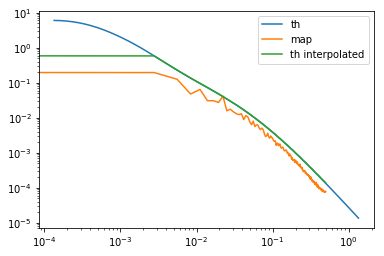

In [13]:
loglog(kell_th, ps_halofit_th, label='th')

loglog(kell_map, ps_halofit_map, label='map')

loglog(kell_map, ps_interp, label='th interpolated')
legend()

In [14]:
print('mean:', jnp.mean(ps_halofit_map/ps_interp))
print('var:', jnp.var(ps_halofit_map/ps_interp))
print('ratio:', ps_halofit_map/ps_interp)

mean: 0.54494977
var: 0.00693132
ratio: [0.5602351  0.33400652 0.5450407  0.35030013 0.6659854  0.4193125
 0.5247561  0.57047117 1.0173796  0.45685798 0.5821508  0.5607634
 0.5594425  0.5897086  0.7013601  0.522666   0.75948066 0.7599928
 0.60407543 0.5422407  0.753197   0.56377065 0.6784969  0.7257733
 0.63777316 0.61953336 0.72531974 0.70285547 0.57786393 0.5123268
 0.5615158  0.71000344 0.58452356 0.5731239  0.7008842  0.67910314
 0.6617956  0.59630436 0.6072834  0.6576171  0.5105573  0.6125873
 0.65637565 0.5735014  0.65922874 0.68916917 0.5739631  0.57542443
 0.624565   0.67074966 0.63108814 0.585663   0.59035164 0.627715
 0.6747624  0.65129805 0.58344513 0.6312948  0.5953919  0.5431634
 0.64816356 0.6036996  0.6281227  0.6013835  0.5158801  0.5884385
 0.51025003 0.5260369  0.5236117  0.58602387 0.5406467  0.51160467
 0.61750954 0.5836793  0.59260297 0.53907007 0.61449593 0.5590282
 0.534804   0.5553757  0.5485824  0.5215555  0.6209691  0.5335283
 0.54196155 0.56380236 0.5131585  

In [15]:
size = 360
k1 = np.fft.fftfreq(size)
print(jnp.max(k1))
print(jnp.max(kell_map))
#k2 = np.fft.fftfreq(size)

0.49722221
0.49722227


In [16]:
def make_power_map(power_spectrum, size, kps=None, zero_freq_val=1e7):
  #Ok we need to make a map of the power spectrum in Fourier space
  k1 = np.fft.fftfreq(size)
  k2 = np.fft.fftfreq(size)
  kcoords = np.meshgrid(k1,k2)
  # Now we can compute the k vector
  k = np.sqrt(kcoords[0]**2 + kcoords[1]**2)
  if kps is None:
    kps = np.linspace(0,0.5,len(power_spectrum))
  # And we can interpolate the PS at these positions
  ps_map = np.interp(k.flatten(), kps, power_spectrum).reshape([size,size])
  ps_map = ps_map
  ps_map[0,0] = zero_freq_val
  return ps_map # Carefull, this is not fftshifted

In [17]:
#jnp.sum(power_map_th / power_map_map)
power_map_th = jnp.array(make_power_map(ps_interp, map_size, kps=kell_map))
power_map_map = jnp.array(make_power_map(ps_halofit_map, map_size, kps=kell_map))

print('mean:', jnp.mean(power_map_map / power_map_th))
print('var:', jnp.var(power_map_map / power_map_th))
print('ratio:', power_map_map / power_map_th)

mean: 0.5289248
var: 0.0027408157
ratio: [[1.         0.33400655 0.54504067 ... 0.35030016 0.54504067 0.33400655]
 [0.33400655 0.38007396 0.5149601  ... 0.38838133 0.5149601  0.38007396]
 [0.54504067 0.5149601  0.40082374 ... 0.51473296 0.40082374 0.5149601 ]
 ...
 [0.35030016 0.38838133 0.51473296 ... 0.61770284 0.51473296 0.38838133]
 [0.54504067 0.5149601  0.40082374 ... 0.51473296 0.40082374 0.5149601 ]
 [0.33400655 0.38007396 0.5149601  ... 0.38838133 0.5149601  0.38007396]]


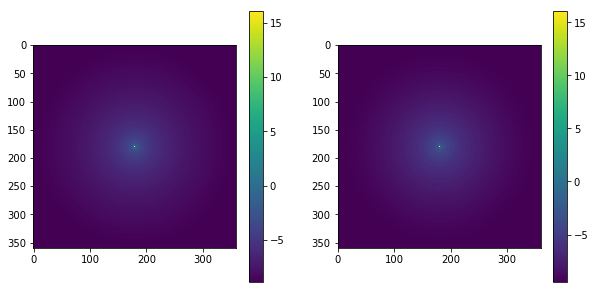

In [18]:
figure(figsize(10,5))
subplot(121)
imshow(jnp.log(jnp.fft.fftshift(power_map_th)))
colorbar()
subplot(122)
imshow(jnp.log(jnp.fft.fftshift(power_map_map)))
colorbar()

Test on a new map

In [19]:
ind = 2
map_data = batch['x'][ind,...,0]

data_ft = jnp.fft.fft2(map_data) / float(map_size)
jnp.mean(jnp.real(data_ft*jnp.conj(data_ft)) / (power_map_th))

DeviceArray(0.48398575, dtype=float32)

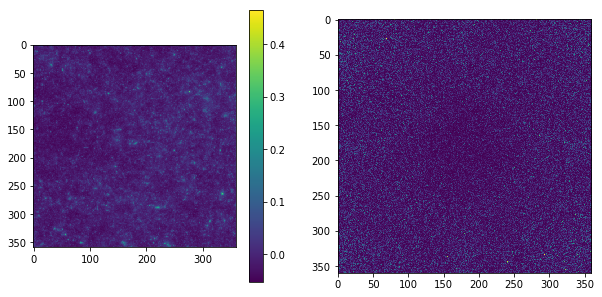

In [20]:
data_ft = jnp.fft.fft2(map_data) / map_size
recon = jnp.real(data_ft*jnp.conj(data_ft)) / (power_map_th)
subplot(121)
imshow(map_data)#, vmin=vmin, vmax=vmax)
colorbar()
subplot(122)
imshow(recon)#, vmin=vmin, vmax=vmax)colorbar()

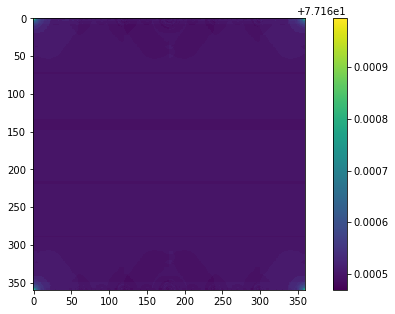

In [21]:
map_recon = jnp.real(jnp.fft.fft2(power_map_map))/ map_size / map_size 
imshow(map_recon)
colorbar()

Summary

In [22]:
# load theoretical power spectrum
ps_data_th = onp.load(gaussian_path).astype('float32')

# calibration
ell_th = jnp.array(ps_data_th[0,:])
ps_halofit_th = jnp.array(ps_data_th[1,:] / pixel_size**2)
kell_th = ell_th /2/jnp.pi * 360 * pixel_size / map_size

# Interpolate the Power Spectrum in Fourier Space
power_map_th = jnp.array(make_power_map(ps_halofit_th, map_size, kps=kell_th))

In [23]:
# evaluate
data_ft = jnp.fft.fft2(map_data) / float(map_size)
jnp.mean(jnp.real(data_ft*jnp.conj(data_ft)) / (power_map_th))

DeviceArray(0.50920546, dtype=float32)

## Compute MAP in the gaussian case

Load data

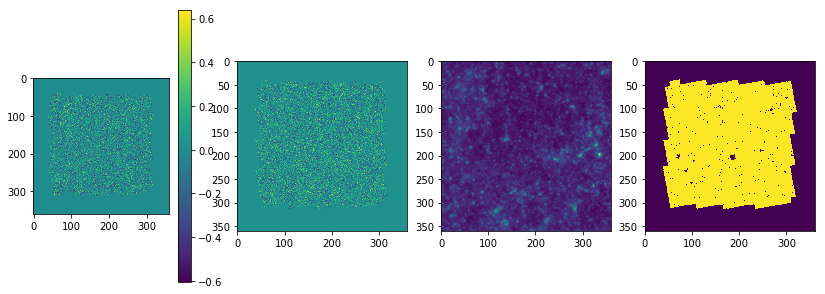

In [24]:
meas_shear = fits.getdata('../data/ktng/ktng_cosmos_e360.fits').astype('float32')
convergence = fits.getdata('../data/ktng/ktng_cosmos_kappa360.fits').astype('float32')
mask = fits.getdata('../data/COSMOS/cosmos_full_mask_0.29arcmin360.fits').astype('float32')

#meas_shear = jnp.stack(ks93inv(convergence, jnp.zeros_like(convergence)), axis=-1)

mask = jnp.expand_dims(mask, -1)
masked_true_shear = meas_shear * mask

figure(figsize(14,5))
subplot(141)
imshow(masked_true_shear[..., 0])
colorbar()
subplot(142)
imshow(masked_true_shear[..., 1])
subplot(143)
imshow(convergence)
subplot(144)
imshow(mask[...,0])

Define prior and likelihood

In [25]:
def log_gaussian_prior(map_data, sigma, ps_map):
    data_ft = jnp.fft.fft2(map_data) / float(map_size)
    return -0.5*jnp.sum(jnp.real(data_ft*jnp.conj(data_ft)) / (ps_map+sigma**2))

gaussian_prior_score = jax.vmap(jax.grad(log_gaussian_prior), in_axes=[0,0, None])

In [26]:
def log_likelihood(x, sigma, meas_shear, mask):
    """ Likelihood function at the level of the measured shear
    """
    ke = x.reshape((map_size, map_size))
    kb = jnp.zeros(ke.shape)
    model_shear = jnp.stack(ks93inv(ke, kb), axis=-1)
    #if FLAGS.reduced_shear:
    #    model_shear = model_shear /( 1. - jnp.clip(jnp.expand_dims(ke,axis=-1), -1., 0.9))
    return - jnp.sum(mask*(model_shear - meas_shear)**2/((sigma_gamma)**2 + sigma**2) )/2.

likelihood_score = jax.vmap(jax.grad(log_likelihood), in_axes=[0,0, None, None])

In [27]:
def total_score_fn(x, sigma):
    """ Compute the total score, combining the following components:
        gaussian prior, ml prior, data likelihood
    """
    data_score = likelihood_score(x, sigma, meas_shear, mask)
    gaussian_score = gaussian_prior_score(kappa_init, sigma, power_map_th)
    return (data_score + gaussian_score)
#    return (data_score)
#    return (gaussian_score)

In [28]:
import numpy as onp
kappa_init = onp.random.randn(map_size, map_size)
kappa_init = jnp.expand_dims(kappa_init, axis=0) * 0.1
sigma = jnp.zeros((1,1,1))

In [29]:
total_score_fn(kappa_init, sigma).shape

(1, 360, 360)

In [30]:
# compute MAP update
eps = 1e-8

@jax.jit
def update(x_old):
    gradient = total_score_fn(kappa_init, sigma)
    x_new = x_old + eps * gradient
    return x_new

In [31]:
x_old = kappa_init.copy()
loss = []
samples = []

n_steps = 7000

for i in tqdm(range(n_steps)):
    x_new = update(x_old)
    l = jnp.mean(mask[...,0]*(jnp.linalg.norm(convergence[...,0] - x_new[0,...])))
    loss.append(l)
    samples.append(x_new)
    x_old = x_new

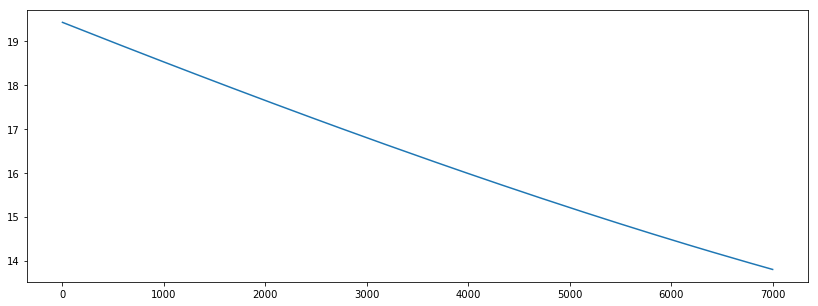

In [32]:
plot(loss)

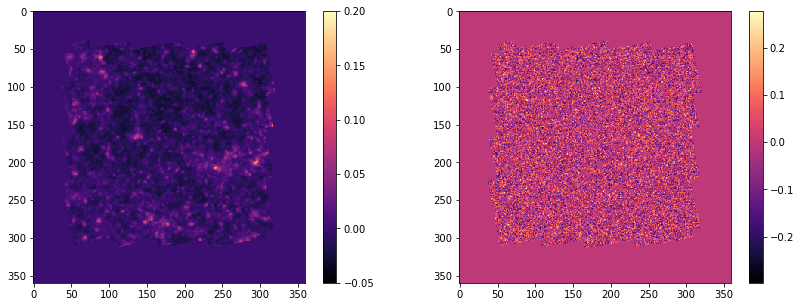

In [33]:
vmin = -0.05
vmax = 0.2

subplot(121)
imshow((jnp.expand_dims(convergence, -1)*mask)[...,0], cmap='magma', vmin=vmin, vmax=vmax)
colorbar()
subplot(122)
imshow(mask[...,0]*x_new[0,...], cmap='magma')#, vmin=vmin, vmax=vmax)
colorbar()